# Question 4: Can we predict future bookings, review scores and price per night?

So far, we considered three main features that we compared with all the others: the number of bookings, the average review score, and the price.
The correlation of these three parameters with the other features is summarized in the following scatter plots.

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, make_scorer, mean_squared_error, mean_absolute_error,explained_variance_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, InputLayer, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError 
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.ticker as ticker

%matplotlib inline

In [2]:
seattle_listings = pd.read_csv('Seattle/seattle_listings_preprocessed.csv')
seattle_listings_encoded = pd.read_csv('Seattle/seattle_listings_preprocessed_encoded.csv')

In [3]:
seattle_listings = seattle_listings.drop(['Unnamed: 0'], axis=1)
seattle_listings_encoded = seattle_listings_encoded.drop(['Unnamed: 0'], axis=1)

In [4]:
seattle_listings_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382 entries, 0 to 2381
Data columns (total 92 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   host_since                               2382 non-null   object 
 1   host_response_rate                       2382 non-null   float64
 2   host_is_superhost                        2382 non-null   bool   
 3   host_has_profile_pic                     2382 non-null   bool   
 4   host_identity_verified                   2382 non-null   bool   
 5   latitude                                 2382 non-null   float64
 6   longitude                                2382 non-null   float64
 7   accommodates                             2382 non-null   int64  
 8   bathrooms                                2382 non-null   float64
 9   bedrooms                                 2382 non-null   float64
 10  beds                                     2382 no

In [5]:
seattle_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382 entries, 0 to 2381
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_since                        2382 non-null   object 
 1   host_response_rate                2382 non-null   float64
 2   host_is_superhost                 2382 non-null   bool   
 3   host_has_profile_pic              2382 non-null   bool   
 4   host_identity_verified            2382 non-null   bool   
 5   neighbourhood                     2382 non-null   object 
 6   latitude                          2382 non-null   float64
 7   longitude                         2382 non-null   float64
 8   property_type                     2382 non-null   object 
 9   room_type                         2382 non-null   object 
 10  accommodates                      2382 non-null   int64  
 11  bathrooms                         2382 non-null   float64
 12  bedroo

## Initial considerations
So far, we considered three main features that we compared with all the others: the number of bookings, the average review score, and the price.
The correlation of these three parameters with the other features is summarized in the following  plots.

In [6]:
import matplotlib.patches as patches

corr = seattle_listings.corr()

bookings_corr = corr.sort_values(by='number_of_bookings', ascending=False)
reviews_corr = corr.sort_values('avg_reviews', ascending=False)
price_corr = corr.sort_values('price', ascending=False)

In [7]:
reviews_corr = reviews_corr.drop(['review_scores_rating',       
                                    'review_scores_accuracy',     
                                    'review_scores_cleanliness',  
                                    'review_scores_checkin',      
                                    'review_scores_communication',
                                    'review_scores_location',     
                                    'review_scores_value'         ], 
                                     axis = 1)

In [8]:
reviews_corr = reviews_corr.drop(['review_scores_rating',       
                                    'review_scores_accuracy',     
                                    'review_scores_cleanliness',  
                                    'review_scores_checkin',      
                                    'review_scores_communication',
                                    'review_scores_location',     
                                    'review_scores_value'         ], 
                                     axis = 0)

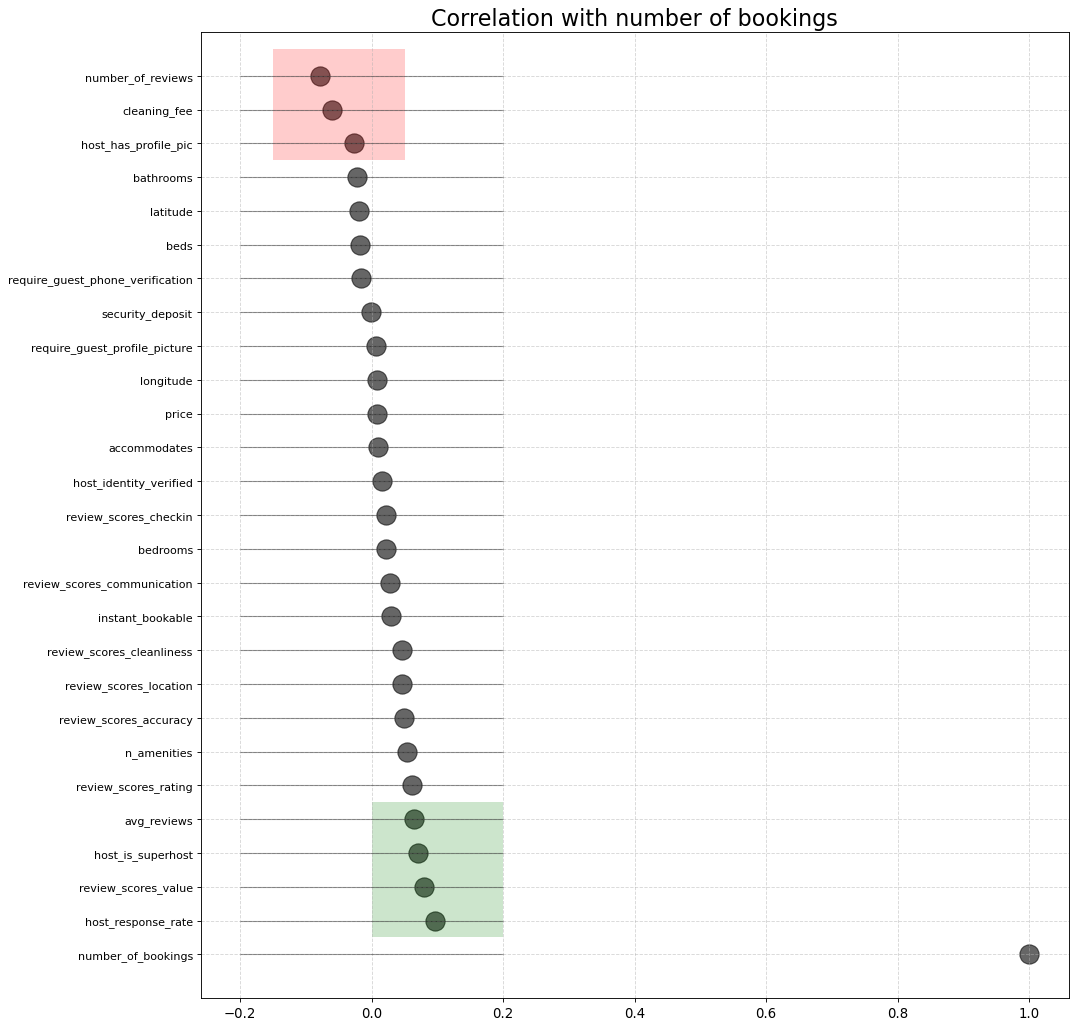

In [9]:
plt.figure(figsize=(14,16), dpi= 80)
plt.hlines(y=bookings_corr.index, xmin=-0.2, xmax=0.2, alpha=0.4, color='black', linewidth=1)
plt.scatter(bookings_corr.number_of_bookings, bookings_corr.index, color='black', s=300, alpha=0.6)
plt.xticks(fontsize=12)

# Add Patches
p1 = patches.Rectangle((0., 0.5), width=.2, height=4, alpha=.2, facecolor='green')
p2 = patches.Rectangle((-0.15, 23.5), width=.2, height=3.3, alpha=.2, facecolor='red')
plt.gca().add_patch(p1)
plt.gca().add_patch(p2)

# Decorate
plt.title('Correlation with number of bookings', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
# plt.show()
plt.savefig('corr_bookings.png', bbox_inches='tight');

The number of bookings well correlates with 
- The host response rate
- The value review score
- If a host is a super host
- The average reviews

The strongest anti-correlation is observed for:
- The number of reviews
- The cleaning fee
- If the host has a profile picture
- the number of bathrooms in the property

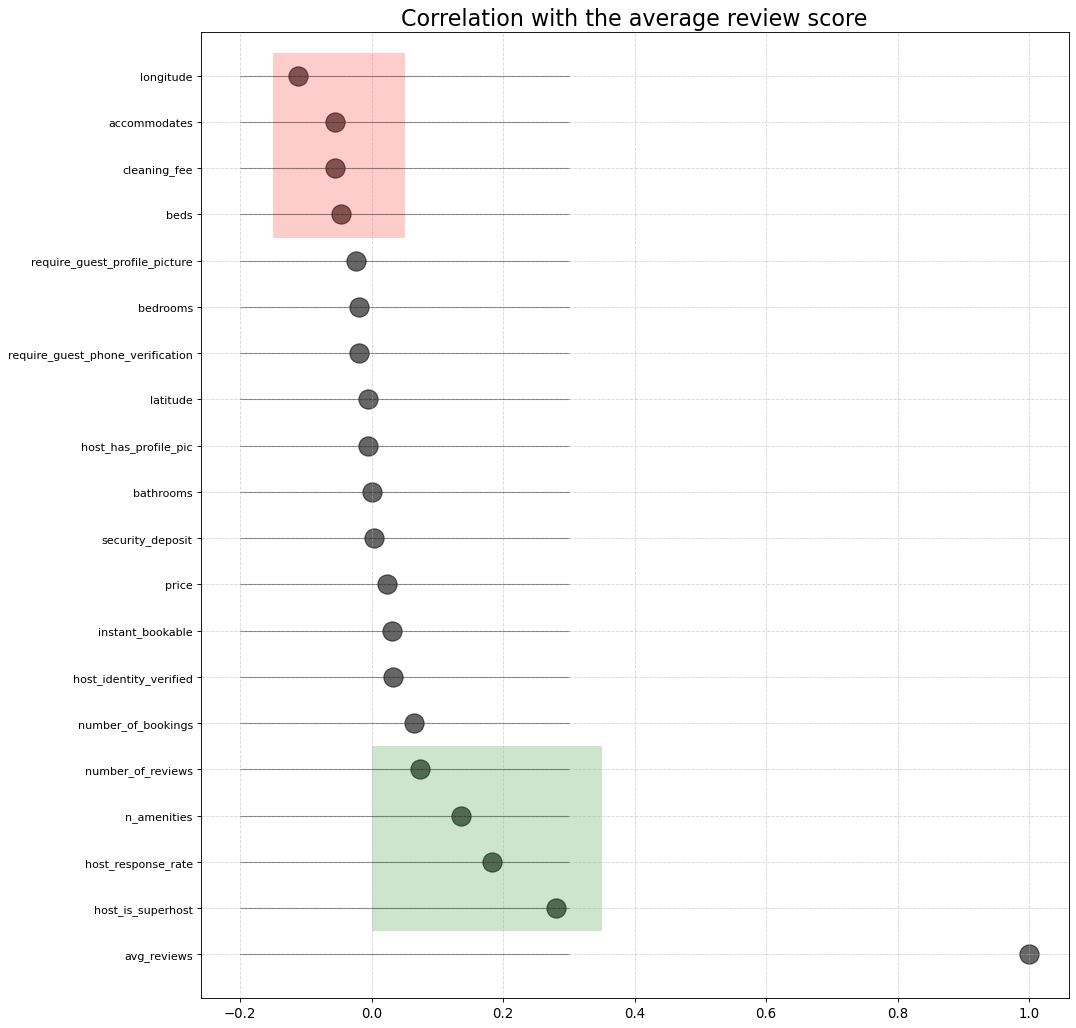

In [10]:
plt.figure(figsize=(14,16), dpi= 80)
plt.hlines(y=reviews_corr.index, xmin=-0.2, xmax=0.3, alpha=0.4, color='black', linewidth=1)
plt.scatter(reviews_corr.avg_reviews, reviews_corr.index, color='black', s=300, alpha=0.6)
plt.xticks(fontsize=12)

# Add Patches
p1 = patches.Rectangle((0., 0.5), width=.35, height=4, alpha=.2, facecolor='green')
p2 = patches.Rectangle((-0.15, 15.5), width=.2, height=4, alpha=.2, facecolor='red')
plt.gca().add_patch(p1)
plt.gca().add_patch(p2)

# Decorate
plt.title('Correlation with the average review score', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
# plt.show()
plt.savefig('corr_review.png', bbox_inches='tight');

The best correlation of the average reviews are with:
- Host is a super host
- The host response rate
- The number of amenities offered
- The number of review

Anti correlations:
- Longitude
- Number of guests a property can accommodate
- Cleaning fees
- Number of beds

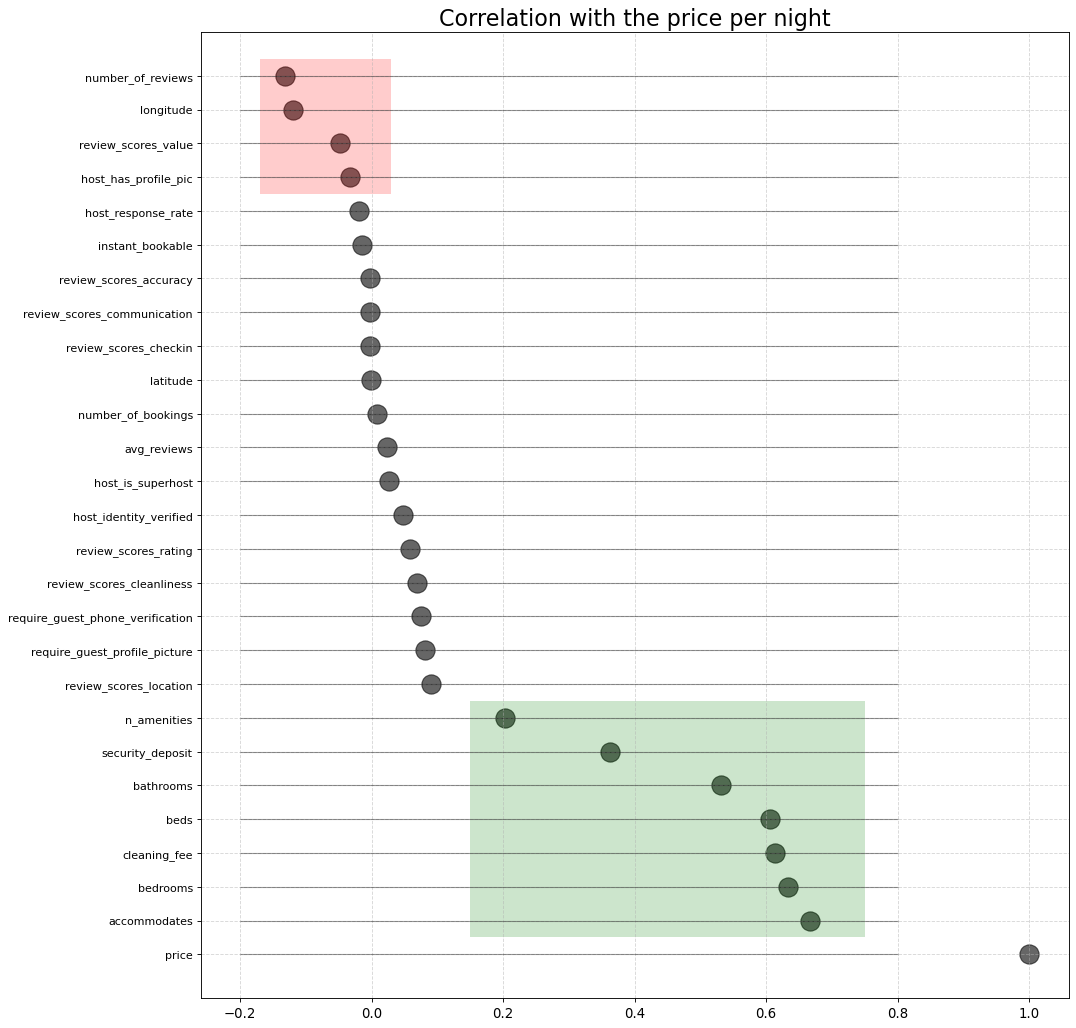

In [11]:
plt.figure(figsize=(14,16), dpi= 80)
plt.hlines(y=price_corr.index, xmin=-0.2, xmax=0.8, alpha=0.4, color='black', linewidth=1)
plt.scatter(price_corr.price, price_corr.index, color='black', s=300, alpha=0.6)
plt.xticks(fontsize=12)

# Add Patches
p1 = patches.Rectangle((0.15, 0.5), width=.6, height=7, alpha=.2, facecolor='green')
p2 = patches.Rectangle((-0.17, 22.5), width=.2, height=4, alpha=.2, facecolor='red')
plt.gca().add_patch(p1)
plt.gca().add_patch(p2)

# Decorate
plt.title('Correlation with the price per night', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
# plt.show()
plt.savefig('corr_price.png', bbox_inches='tight');

In [12]:
categorical = seattle_listings_encoded.select_dtypes(include=['int64'])

In [13]:
categorical['price'] = seattle_listings_encoded['price']

<ipython-input-13-830eb06a20cf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical['price'] = seattle_listings_encoded['price']


In [14]:
categorical['avg_reviews'] = seattle_listings_encoded['avg_reviews']

<ipython-input-14-a9ad197a4d5c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical['avg_reviews'] = seattle_listings_encoded['avg_reviews']


In [15]:
corr_e = categorical.corr()

bookings_corr_e = corr_e.sort_values(by='number_of_bookings', ascending=False)
reviews_corr_e = corr_e.sort_values('avg_reviews', ascending=False)
price_corr_e = corr_e.sort_values('price', ascending=False)

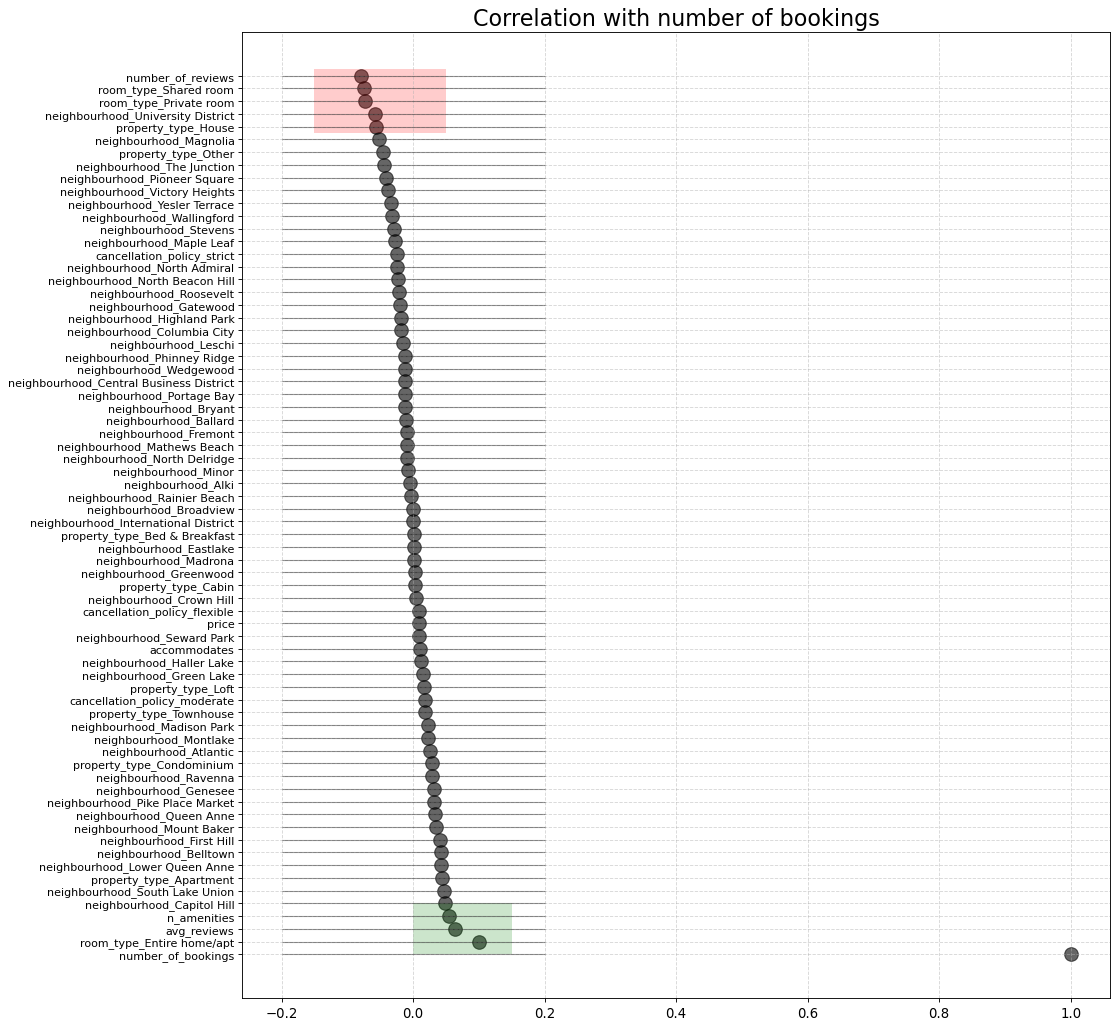

In [16]:
plt.figure(figsize=(14,16), dpi= 80)
plt.hlines(y=bookings_corr_e.index, xmin=-0.2, xmax=0.2, alpha=0.4, color='black', linewidth=1)
plt.scatter(bookings_corr_e.number_of_bookings, bookings_corr_e.index, color='black', s=150, alpha=0.6)
plt.xticks(fontsize=12)

# Add Patches
p1 = patches.Rectangle((0., 0.), width=0.15, height=4, alpha=.2, facecolor='green')
p2 = patches.Rectangle((-0.15, 64.5), width=.2, height=5, alpha=.2, facecolor='red')
plt.gca().add_patch(p1)
plt.gca().add_patch(p2)

# Decorate
plt.title('Correlation with number of bookings', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
# plt.show()
plt.savefig('corr_bookings_encoded.png', bbox_inches='tight');

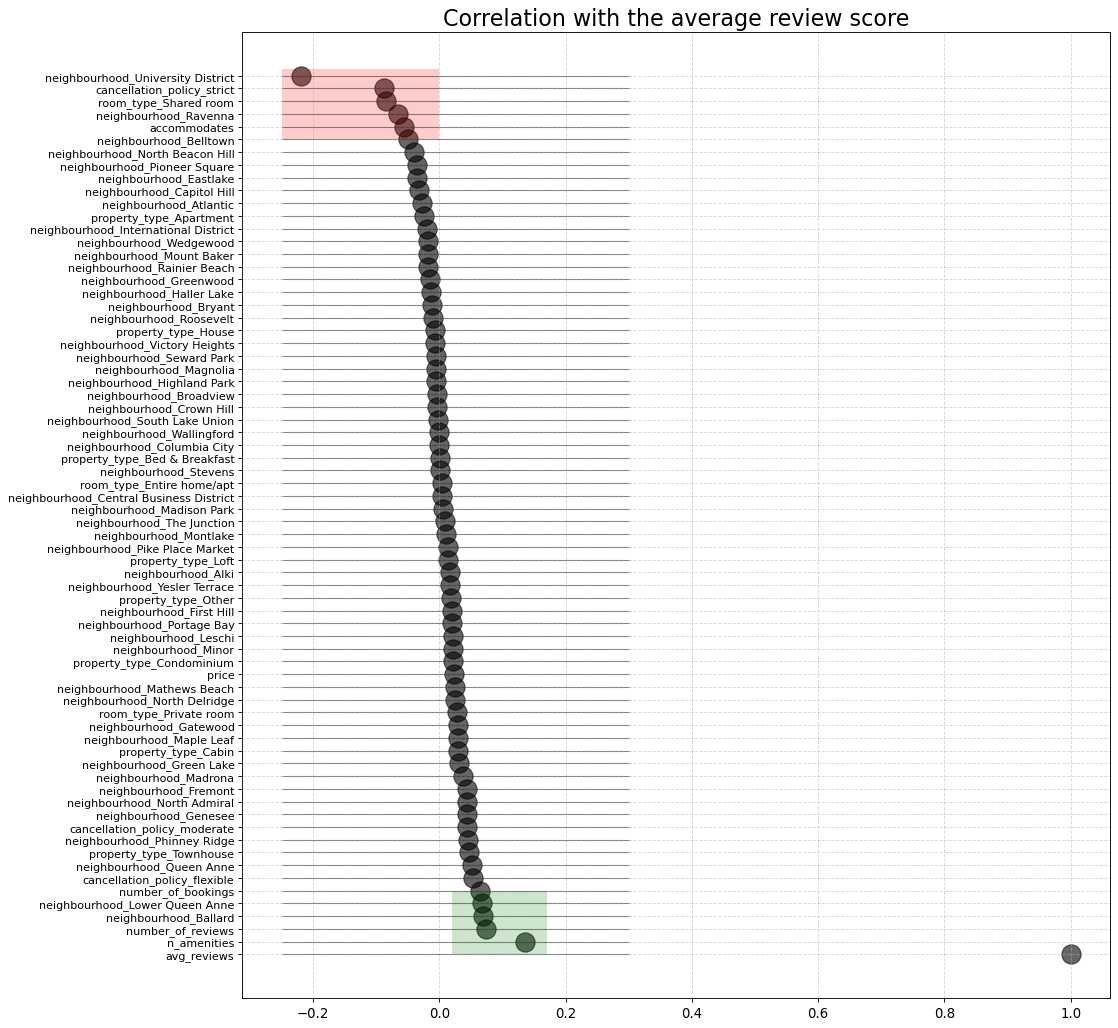

In [17]:
plt.figure(figsize=(14,16), dpi= 80)
plt.hlines(y=reviews_corr_e.index, xmin=-0.25, xmax=0.3, alpha=0.4, color='black', linewidth=1)
plt.scatter(reviews_corr_e.avg_reviews, reviews_corr_e.index, color='black', s=300, alpha=0.6)
plt.xticks(fontsize=12)

# Add Patches
p1 = patches.Rectangle((0.02, 0), width=.15, height=5, alpha=.2, facecolor='green')
p2 = patches.Rectangle((-0.25, 64), width=.25, height=5.5, alpha=.2, facecolor='red')
plt.gca().add_patch(p1)
plt.gca().add_patch(p2)

# Decorate
plt.title('Correlation with the average review score', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
# plt.show()
plt.savefig('corr_review_encoded.png', bbox_inches='tight');

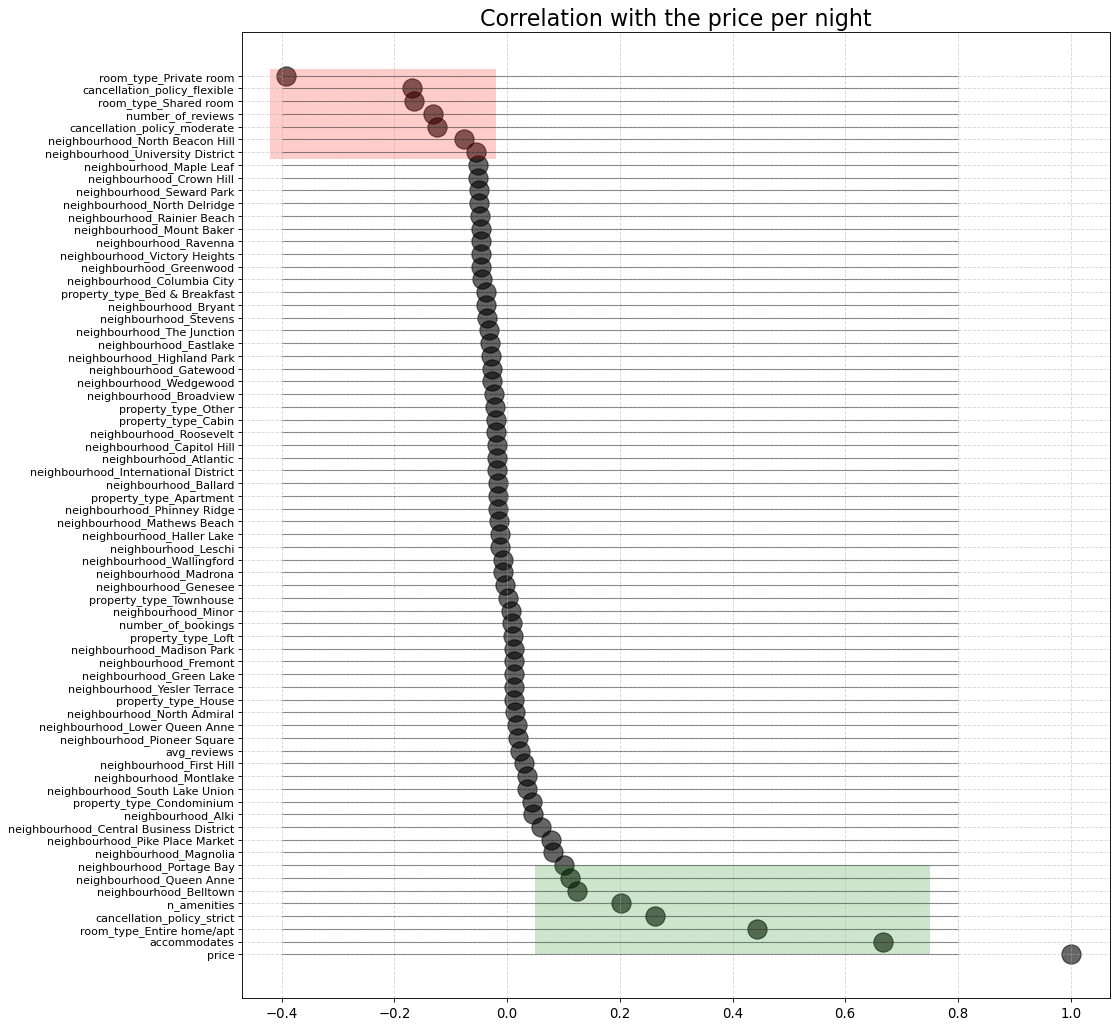

In [18]:
plt.figure(figsize=(14,16), dpi= 80)
plt.hlines(y=price_corr_e.index, xmin=-0.4, xmax=0.8, alpha=0.4, color='black', linewidth=1)
plt.scatter(price_corr_e.price, price_corr_e.index, color='black', s=300, alpha=0.6)
plt.xticks(fontsize=12)

# Add Patches
p1 = patches.Rectangle((0.05, 0.0), width=.7, height=7, alpha=.2, facecolor='green')
p2 = patches.Rectangle((-0.42, 62.5), width=.4, height=7, alpha=.2, facecolor='red')
plt.gca().add_patch(p1)
plt.gca().add_patch(p2)

# Decorate
plt.title('Correlation with the price per night', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
# plt.show()
plt.savefig('corr_price_encoded.png', bbox_inches='tight');

The main correlation is now also with "room type entire home/apt", the neighborhoods Capitol Hill and South Lake Union. Negative correlations are also with: "room type entire shared room", "room type private room", and the neighborhood University District.  

For the average reviews, the new positive high correlation is with the neighborhoods Ballard and Queen Ann, while University District and Ravenna have the highest anti correlations.  

The price per night is well correlated with "room type entire home/apt" and the neighborhoods Belltown and Queen Ann, while it is negatively correlated with "room type entire shared room", Cancellation policy moderate, and the neighborhoods North Beacon hill and University District.

credit fro the plots: https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/

# The models

I will apply different models to predict future bookings, review scores, and price per night. 
The models will follow these **steps**:

1. For each dataset (bookings_corr_e, reviews_corr_e, and price_corr_e), the number of columns will be reduced by removing those having close to 0 and negative correlation with the number of bookings/average review score/price per night.
2. Split the dataset in train and test data.
3. Instantiate the selected model, using normalized when it is appropriate.
4. Fit the model on the training data.
5. Predict the feature in analysis by using the test data.
6. Score the model on the test data
7. Analyze the results.
8. Conclusions.

## 1. Predicting future bookings

### Step 1

In [19]:
b = bookings_corr_e['number_of_bookings']
df_bookings_corr_e = seattle_listings_encoded[b[b > 0.02].index.values]

In [20]:
df_bookings_corr_e.head()

,number_of_bookings,room_type_Entire home/apt,avg_reviews,n_amenities,neighbourhood_Capitol Hill,neighbourhood_South Lake Union,property_type_Apartment,neighbourhood_Lower Queen Anne,neighbourhood_Belltown,neighbourhood_First Hill,neighbourhood_Mount Baker,neighbourhood_Queen Anne,neighbourhood_Pike Place Market,neighbourhood_Genesee,neighbourhood_Ravenna,property_type_Condominium,neighbourhood_Atlantic,neighbourhood_Montlake,neighbourhood_Madison Park
0,19,1,9.83,10,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,74,1,10.00,16,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,145,1,10.00,21,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,1,9.33,13,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,19,0,10.00,7,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [21]:
df_bookings_corr_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382 entries, 0 to 2381
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_bookings               2382 non-null   int64  
 1   room_type_Entire home/apt        2382 non-null   int64  
 2   avg_reviews                      2382 non-null   float64
 3   n_amenities                      2382 non-null   int64  
 4   neighbourhood_Capitol Hill       2382 non-null   int64  
 5   neighbourhood_South Lake Union   2382 non-null   int64  
 6   property_type_Apartment          2382 non-null   int64  
 7   neighbourhood_Lower Queen Anne   2382 non-null   int64  
 8   neighbourhood_Belltown           2382 non-null   int64  
 9   neighbourhood_First Hill         2382 non-null   int64  
 10  neighbourhood_Mount Baker        2382 non-null   int64  
 11  neighbourhood_Queen Anne         2382 non-null   int64  
 12  neighbourhood_Pike P

### Step 2

In [23]:
X = df_bookings_corr_e
X = X.drop('number_of_bookings', axis=1)

y = df_bookings_corr_e.number_of_bookings.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

### Steps 3 to 6

In [24]:
def models(selected_model):
    
    # Instantiate and fit the model
    model = selected_model
    model.fit(X_train, y_train)

    # Predict
    y_test_preds = model.predict(X_test)

    # Score the result
    print(f'The r^2 error is {r2_score(y_test, y_test_preds):.4f}') 
    print(f'The Root Mean Square Error (RMSE) is {np.sqrt(mean_squared_error(y_test, y_test_preds)):.4f}')
    
    # Compare the actual and the predicted data
    preds_vs_act = pd.DataFrame(np.hstack([y_test.reshape(y_test.size,1), y_test_preds.reshape(y_test.size,1)]))
    preds_vs_act.columns = ['actual', 'preds']
    preds_vs_act['diff'] = preds_vs_act['actual'] - preds_vs_act['preds']
    preds_vs_act.head(15)
    
    # Plot the actual vs the predicted data
    
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    fig.subplots_adjust(wspace=.5)

    ax[0].plot(preds_vs_act['preds'], preds_vs_act['diff'], linewidth=0, marker='o', alpha=0.5)
    ax[0].set(xlabel='predicted', ylabel='difference')
    
    ax[1].plot(preds_vs_act['preds'], preds_vs_act['actual'], linewidth=0, marker='o', alpha=0.5)
    ax[1].set(xlabel='predicted', ylabel='actual');
    
    return model

In [25]:
def ann_models(X_train, X_test, hidden=1, neurons=20, learning_rate=3e-3, dropout=0.15):
    
    # Scale the data
    scaler = MinMaxScaler()
    X_train= scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Create the model
    
    input_shape=[X_train.shape[1]]
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    
    for hid in range(hidden):
        model.add(Dense(neurons,activation='relu'))
        model.add(Dropout(dropout))
    
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer='adam',loss='mse', metrics=[RootMeanSquaredError(name='rmse')])
    
    # Train the model
    model.fit(x=X_train,
              y=y_train,
              validation_data=(X_test,y_test),  
              epochs=200,
              callbacks=[EarlyStopping(patience=20)])
    
    # losses
    losses = pd.DataFrame(model.history.history)
    
    plt.figure(figsize=(10,8))
    losses.plot()
    plt.xlabel('Epochs')
    plt.ylabel('Errors')
    plt.savefig('Epochs_Errors.png', bbox_inches='tight')
    
    # predictions
    predictions = model.predict(X_test)
    
    print(f'The Mean Absolute Error is {mean_absolute_error(y_test,predictions):.4f}')
    print(f'The Root Mean Square Error (RMSE) is {np.sqrt(mean_squared_error(y_test, predictions)):.4f}')
    print(f'The Explained Variance Score (EVS) is {explained_variance_score(y_test,predictions):.4f}')
    
    plt.figure(figsize=(10,8))
    
    # Plot the results
    # Our predictions
    plt.scatter(y_test,predictions, linewidth=0, marker='o', alpha=0.5)
    # Perfect predictions
    plt.plot(y_test,y_test,'r')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.savefig('Actual_Predicted.png', bbox_inches='tight')
    
    # Error
    shape = X_test.shape[0]
    errors = y_test.reshape(shape, 1) - predictions
    
    plt.figure(figsize=(10,8))
    sns.histplot(errors)
    plt.savefig('Hist_errors.png', bbox_inches='tight')
    
    return model

# Predicting future bookings

### First Model: Linear Regression

The r^2 error is 0.0090
The Root Mean Square Error (RMSE) is 121.0976


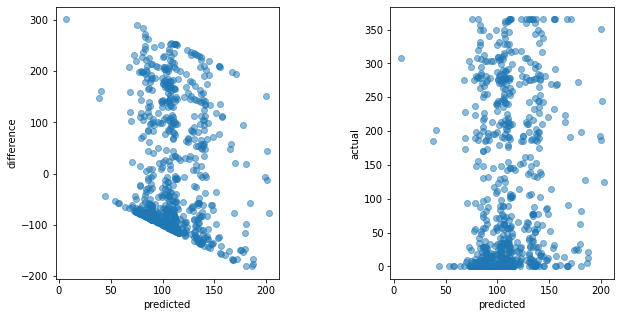

In [26]:
lr_model = models(LinearRegression(normalize=True))

In [27]:
coefs_df = pd.DataFrame()

coefs_df['Most_influencing_features'] = X_train.columns
coefs_df['coefficient'] = lr_model.coef_
coefs_df['absolute_coefficient'] = np.abs(lr_model.coef_)

coefs_df.sort_values('absolute_coefficient', ascending=False).head(10)

,Most_influencing_features,coefficient,absolute_coefficient
4,neighbourhood_South Lake Union,93.512016,93.512016
12,neighbourhood_Genesee,76.991180,76.991180
6,neighbourhood_Lower Queen Anne,73.796143,73.796143
9,neighbourhood_Mount Baker,58.971804,58.971804
16,neighbourhood_Montlake,57.806017,57.806017
15,neighbourhood_Atlantic,55.100511,55.100511
17,neighbourhood_Madison Park,44.135135,44.135135
13,neighbourhood_Ravenna,42.533503,42.533503
11,neighbourhood_Pike Place Market,38.400926,38.400926
3,neighbourhood_Capitol Hill,34.532262,34.532262


### Second Model: Random Forest Regression

The r^2 error is -0.1101
The Root Mean Square Error (RMSE) is 128.1683


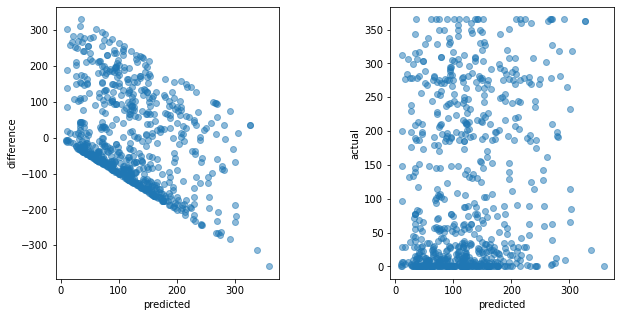

In [30]:
rf_model = models(RandomForestRegressor(n_estimators=500,
                                criterion='poisson')) 

In [33]:
coefs_df = pd.DataFrame()

coefs_df['Most_influencing_features'] = X_train.columns
coefs_df['coefficient'] = rf_model.feature_importances_
coefs_df['absolute_coefficient'] = np.abs(rf_model.feature_importances_)

coefs_df.sort_values('absolute_coefficient', ascending=False).head(10)

,Most_influencing_features,coefficient,absolute_coefficient
2,n_amenities,0.412089,0.412089
1,avg_reviews,0.284911,0.284911
0,room_type_Entire home/apt,0.121235,0.121235
5,property_type_Apartment,0.104509,0.104509
3,neighbourhood_Capitol Hill,0.012288,0.012288
7,neighbourhood_Belltown,0.009867,0.009867
6,neighbourhood_Lower Queen Anne,0.008668,0.008668
14,property_type_Condominium,0.007812,0.007812
10,neighbourhood_Queen Anne,0.007435,0.007435
12,neighbourhood_Genesee,0.005095,0.005095


### Third Model: Gradient Boosting Regressor

The r^2 error is 0.0143
The Root Mean Square Error (RMSE) is 120.7703


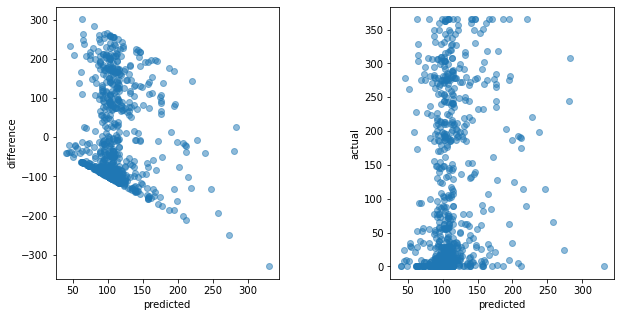

In [35]:
gbr_model = models(GradientBoostingRegressor())

In [36]:
coefs_df = pd.DataFrame()

coefs_df['Most_influencing_features'] = X_train.columns
coefs_df['coefficient'] = gbr_model.feature_importances_
coefs_df['absolute_coefficient'] = np.abs(gbr_model.feature_importances_)

coefs_df.sort_values('absolute_coefficient', ascending=False).head(10)

,Most_influencing_features,coefficient,absolute_coefficient
2,n_amenities,0.402692,0.402692
1,avg_reviews,0.198277,0.198277
0,room_type_Entire home/apt,0.059967,0.059967
3,neighbourhood_Capitol Hill,0.052682,0.052682
5,property_type_Apartment,0.042400,0.042400
6,neighbourhood_Lower Queen Anne,0.039676,0.039676
14,property_type_Condominium,0.025493,0.025493
13,neighbourhood_Ravenna,0.024254,0.024254
10,neighbourhood_Queen Anne,0.021919,0.021919
9,neighbourhood_Mount Baker,0.020521,0.020521


### Fourth Model: ANN

Epoch 1/200
53/53 [==============================] - 0s 3ms/step - loss: 26280.8496 - rmse: 162.1137 - val_loss: 27327.6309 - val_rmse: 165.3107
Epoch 2/200
53/53 [==============================] - 0s 2ms/step - loss: 24957.0078 - rmse: 157.9779 - val_loss: 24361.6133 - val_rmse: 156.0821
Epoch 3/200
53/53 [==============================] - 0s 2ms/step - loss: 19602.8418 - rmse: 140.0101 - val_loss: 16041.4717 - val_rmse: 126.6549
Epoch 4/200
53/53 [==============================] - 0s 2ms/step - loss: 15014.3311 - rmse: 122.5330 - val_loss: 14697.0938 - val_rmse: 121.2316
Epoch 5/200
53/53 [==============================] - 0s 2ms/step - loss: 14839.3340 - rmse: 121.8168 - val_loss: 14625.7119 - val_rmse: 120.9368
Epoch 6/200
53/53 [==============================] - 0s 2ms/step - loss: 14475.5186 - rmse: 120.3142 - val_loss: 14640.7383 - val_rmse: 120.9989
Epoch 7/200
53/53 [==============================] - 0s 2ms/step - loss: 14575.0303 - rmse: 120.7271 - val_loss: 14617.3145 - val_

<Figure size 720x576 with 0 Axes>

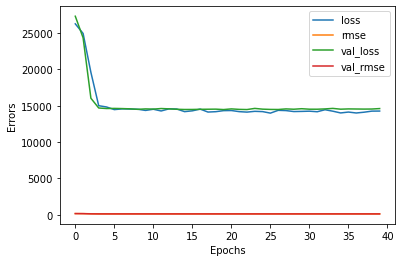

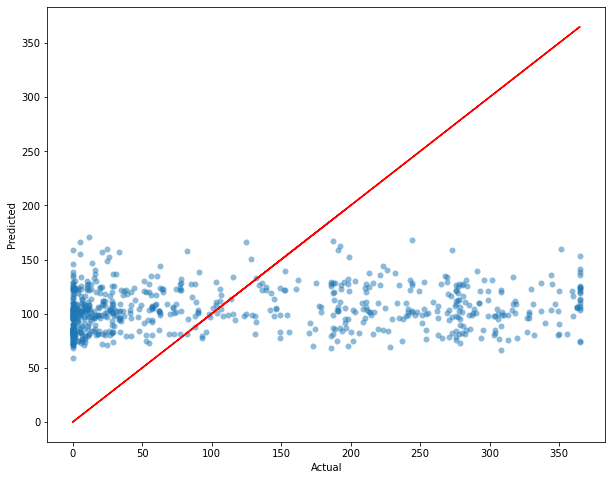

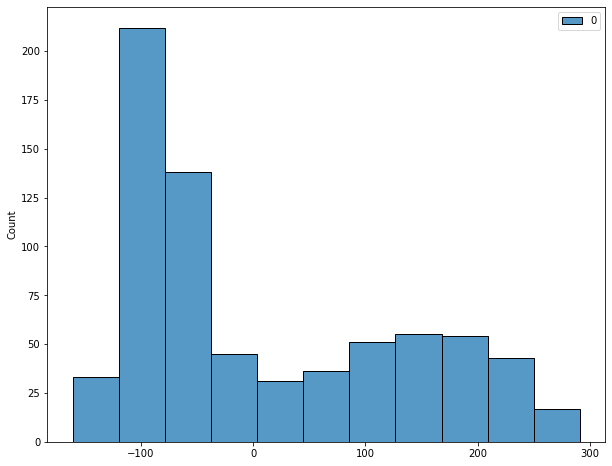

In [38]:
ann_model = ann_models(X_train, X_test, hidden=3, neurons=20, learning_rate=3e-3, dropout=0.15)

### Step 7
The feature "number of bookings" is very hard, if not impossible to model. I tried four different models, including a ANN, but the errors are always very high. Looking at the correlation plots above, this feature hardly correlate with the others.

## 2. Predicting future reviews


### Step 1

In [42]:
b = reviews_corr_e['avg_reviews']
df_reviews_corr_e = seattle_listings_encoded[b[b > 0.02].index.values]

In [43]:
df_reviews_corr_e

,avg_reviews,n_amenities,number_of_reviews,neighbourhood_Ballard,neighbourhood_Lower Queen Anne,number_of_bookings,cancellation_policy_flexible,neighbourhood_Queen Anne,property_type_Townhouse,neighbourhood_Phinney Ridge,...,neighbourhood_Maple Leaf,neighbourhood_Gatewood,room_type_Private room,neighbourhood_North Delridge,neighbourhood_Mathews Beach,price,property_type_Condominium,neighbourhood_Minor,neighbourhood_Leschi,neighbourhood_Portage Bay
0,9.83,10,207,0,0,19,0,1,0,0,...,0,0,0,0,0,85.0,0,0,0,0
1,10.00,16,43,0,0,74,0,1,0,0,...,0,0,0,0,0,150.0,0,0,0,0
2,10.00,21,20,0,0,145,0,1,0,0,...,0,0,0,0,0,975.0,0,0,0,0
3,9.33,13,38,0,0,0,0,1,0,0,...,0,0,0,0,0,450.0,0,0,0,0
4,10.00,7,58,0,0,19,0,1,0,0,...,0,0,1,0,0,80.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2377,9.17,22,5,0,0,138,0,0,0,0,...,0,0,0,0,0,154.0,0,0,0,0
2378,9.50,15,2,0,0,144,0,0,0,0,...,0,0,0,0,0,65.0,0,0,0,0
2379,9.83,19,73,0,0,78,0,0,0,0,...,0,0,0,0,0,95.0,0,0,0,0
2380,8.00,16,1,0,0,333,0,0,0,0,...,0,0,0,0,0,359.0,0,0,0,0


### Step 2

In [44]:
X = df_reviews_corr_e
X = X.drop('avg_reviews', axis=1)

y = df_reviews_corr_e.avg_reviews.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

### Steps 3 to 6

### First Model: Linear Regression

The r^2 error is 0.0707
The Root Mean Square Error (RMSE) is 0.4941


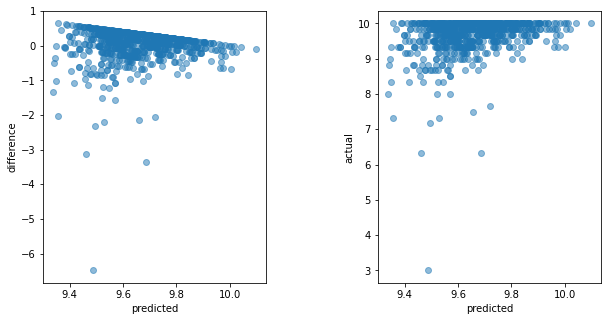

In [45]:
lr_model = models(LinearRegression(normalize=True))

In [46]:
coefs_df = pd.DataFrame()

coefs_df['Most_influencing_features'] = X_train.columns
coefs_df['coefficient'] = lr_model.coef_
coefs_df['absolute_coefficient'] = np.abs(lr_model.coef_)

coefs_df.sort_values('absolute_coefficient', ascending=False).head(10)

,Most_influencing_features,coefficient,absolute_coefficient
3,neighbourhood_Lower Queen Anne,0.295500,0.295500
10,neighbourhood_Genesee,0.281993,0.281993
8,neighbourhood_Phinney Ridge,0.270008,0.270008
20,neighbourhood_Mathews Beach,0.253912,0.253912
11,neighbourhood_North Admiral,0.238711,0.238711
17,neighbourhood_Gatewood,0.208196,0.208196
19,neighbourhood_North Delridge,0.207698,0.207698
16,neighbourhood_Maple Leaf,0.199156,0.199156
13,neighbourhood_Madrona,0.178063,0.178063
2,neighbourhood_Ballard,0.166223,0.166223


### Second Model: Random Forest Regression

The r^2 error is 0.0234
The Root Mean Square Error (RMSE) is 0.5065


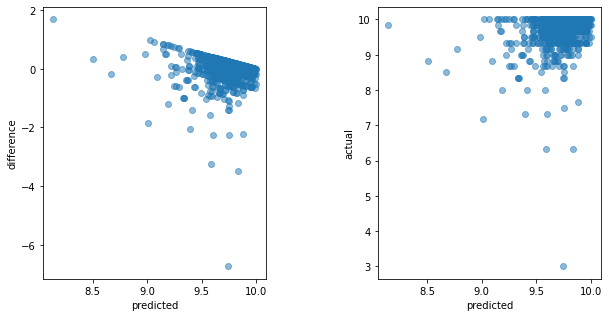

In [47]:
rf_model = models(RandomForestRegressor(n_estimators=500,
                                criterion='poisson')) 

In [48]:
coefs_df = pd.DataFrame()

coefs_df['Most_influencing_features'] = X_train.columns
coefs_df['coefficient'] = rf_model.feature_importances_
coefs_df['absolute_coefficient'] = np.abs(rf_model.feature_importances_)

coefs_df.sort_values('absolute_coefficient', ascending=False).head(10)

,Most_influencing_features,coefficient,absolute_coefficient
1,number_of_reviews,0.227860,0.227860
21,price,0.213192,0.213192
4,number_of_bookings,0.210693,0.210693
0,n_amenities,0.175488,0.175488
9,cancellation_policy_moderate,0.045521,0.045521
18,room_type_Private room,0.033285,0.033285
5,cancellation_policy_flexible,0.032603,0.032603
2,neighbourhood_Ballard,0.007921,0.007921
6,neighbourhood_Queen Anne,0.007105,0.007105
23,neighbourhood_Minor,0.006509,0.006509


### Third Model: Gradient Boosting Regressor

The r^2 error is 0.0546
The Root Mean Square Error (RMSE) is 0.4984


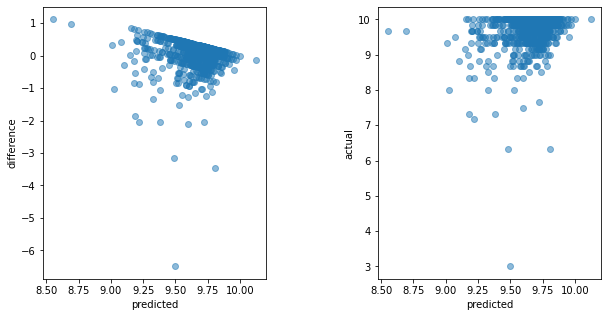

In [49]:
gbr_model = models(GradientBoostingRegressor())

In [50]:
oefs_df = pd.DataFrame()

coefs_df['Most_influencing_features'] = X_train.columns
coefs_df['coefficient'] = gbr_model.feature_importances_
coefs_df['absolute_coefficient'] = np.abs(gbr_model.feature_importances_)

coefs_df.sort_values('absolute_coefficient', ascending=False).head(10)

,Most_influencing_features,coefficient,absolute_coefficient
4,number_of_bookings,0.254109,0.254109
0,n_amenities,0.202227,0.202227
1,number_of_reviews,0.169867,0.169867
21,price,0.158746,0.158746
5,cancellation_policy_flexible,0.039174,0.039174
18,room_type_Private room,0.028617,0.028617
2,neighbourhood_Ballard,0.019365,0.019365
3,neighbourhood_Lower Queen Anne,0.018863,0.018863
12,neighbourhood_Fremont,0.015948,0.015948
7,property_type_Townhouse,0.013600,0.013600


### Fourth Model: ANN

Epoch 1/200
53/53 [==============================] - 0s 3ms/step - loss: 89.4733 - rmse: 9.4590 - val_loss: 76.9344 - val_rmse: 8.7712
Epoch 2/200
53/53 [==============================] - 0s 2ms/step - loss: 53.9731 - rmse: 7.3466 - val_loss: 20.7469 - val_rmse: 4.5549
Epoch 3/200
53/53 [==============================] - 0s 2ms/step - loss: 13.1346 - rmse: 3.6242 - val_loss: 4.2134 - val_rmse: 2.0527
Epoch 4/200
53/53 [==============================] - 0s 2ms/step - loss: 8.9868 - rmse: 2.9978 - val_loss: 2.5844 - val_rmse: 1.6076
Epoch 5/200
53/53 [==============================] - 0s 2ms/step - loss: 7.3088 - rmse: 2.7035 - val_loss: 1.7321 - val_rmse: 1.3161
Epoch 6/200
53/53 [==============================] - 0s 2ms/step - loss: 6.4593 - rmse: 2.5415 - val_loss: 1.2121 - val_rmse: 1.1009
Epoch 7/200
53/53 [==============================] - 0s 3ms/step - loss: 5.9543 - rmse: 2.4401 - val_loss: 1.1211 - val_rmse: 1.0588
Epoch 8/200
53/53 [==============================] - 0s 2ms/step

53/53 [==============================] - 0s 2ms/step - loss: 2.2326 - rmse: 1.4942 - val_loss: 0.2900 - val_rmse: 0.5385
Epoch 63/200
53/53 [==============================] - 0s 1ms/step - loss: 2.0787 - rmse: 1.4418 - val_loss: 0.3816 - val_rmse: 0.6177
Epoch 64/200
53/53 [==============================] - 0s 1ms/step - loss: 2.1333 - rmse: 1.4606 - val_loss: 0.3683 - val_rmse: 0.6069
Epoch 65/200
53/53 [==============================] - 0s 2ms/step - loss: 2.0008 - rmse: 1.4145 - val_loss: 0.2944 - val_rmse: 0.5426
Epoch 66/200
53/53 [==============================] - 0s 2ms/step - loss: 2.1387 - rmse: 1.4624 - val_loss: 0.3223 - val_rmse: 0.5677
Epoch 67/200
53/53 [==============================] - 0s 2ms/step - loss: 1.9798 - rmse: 1.4071 - val_loss: 0.3542 - val_rmse: 0.5951
Epoch 68/200
53/53 [==============================] - 0s 2ms/step - loss: 2.0875 - rmse: 1.4448 - val_loss: 0.2902 - val_rmse: 0.5387
Epoch 69/200
53/53 [==============================] - 0s 2ms/step - loss: 1

<Figure size 720x576 with 0 Axes>

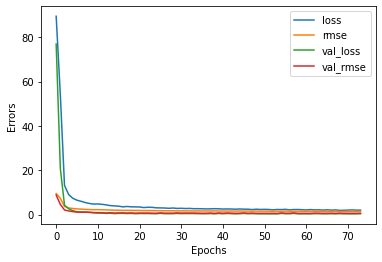

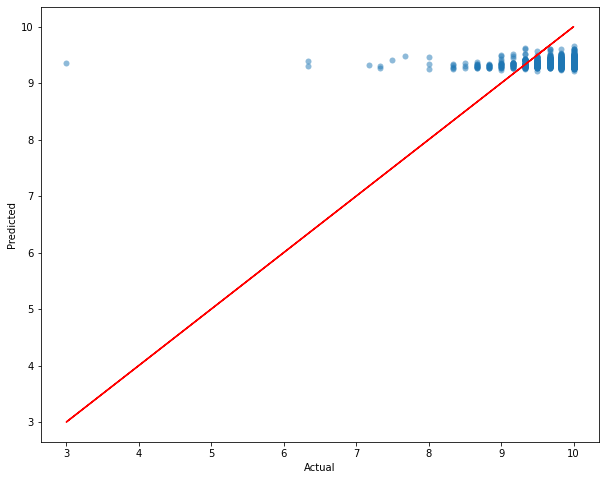

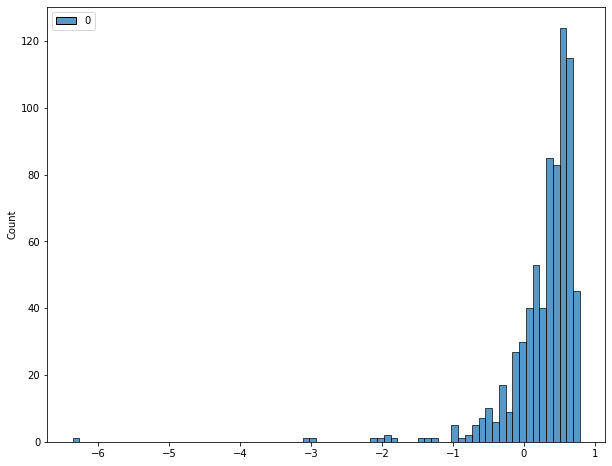

In [51]:
ann_models(X_train, X_test, hidden=3, neurons=20, learning_rate=3e-3, dropout=0.15)

### Step 7

## 2. Predicting price per night



### Step 1

In [52]:
b = price_corr_e['price']
df_price_corr_e = seattle_listings_encoded[b[b > 0.02].index.values]

In [53]:
df_price_corr_e

,price,accommodates,room_type_Entire home/apt,cancellation_policy_strict,n_amenities,neighbourhood_Belltown,neighbourhood_Queen Anne,neighbourhood_Portage Bay,neighbourhood_Magnolia,neighbourhood_Pike Place Market,neighbourhood_Central Business District,neighbourhood_Alki,property_type_Condominium,neighbourhood_South Lake Union,neighbourhood_Montlake,neighbourhood_First Hill,avg_reviews
0,85.0,4,1,0,10,0,1,0,0,0,0,0,0,0,0,0,9.83
1,150.0,4,1,1,16,0,1,0,0,0,0,0,0,0,0,0,10.00
2,975.0,11,1,1,21,0,1,0,0,0,0,0,0,0,0,0,10.00
3,450.0,6,1,1,13,0,1,0,0,0,0,0,0,0,0,0,9.33
4,80.0,2,0,0,7,0,1,0,0,0,0,0,0,0,0,0,10.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2377,154.0,5,1,1,22,0,0,0,0,0,0,0,0,0,0,0,9.17
2378,65.0,3,1,0,15,0,0,0,0,0,0,0,0,0,0,0,9.50
2379,95.0,4,1,0,19,0,0,0,0,0,0,0,0,0,0,0,9.83
2380,359.0,6,1,1,16,0,0,0,0,0,0,0,0,0,0,0,8.00


### Step 2

In [54]:
X = df_reviews_corr_e
X = X.drop('price', axis=1)

y = df_reviews_corr_e.price.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

### Steps 3 to 6

### First Model: Linear Regression

The r^2 error is 0.2470
The Root Mean Square Error (RMSE) is 69.0866


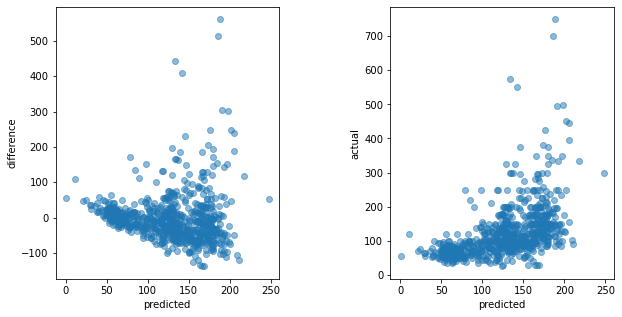

In [55]:
lr_model = models(LinearRegression(normalize=True))

In [56]:
coefs_df = pd.DataFrame()

coefs_df['Most_influencing_features'] = X_train.columns
coefs_df['coefficient'] = lr_model.coef_
coefs_df['absolute_coefficient'] = np.abs(lr_model.coef_)

coefs_df.sort_values('absolute_coefficient', ascending=False).head(10)

,Most_influencing_features,coefficient,absolute_coefficient
25,neighbourhood_Portage Bay,124.096333,124.096333
19,room_type_Private room,-63.562479,63.562479
17,neighbourhood_Maple Leaf,-44.423464,44.423464
6,cancellation_policy_flexible,-39.934178,39.934178
7,neighbourhood_Queen Anne,37.254680,37.254680
10,cancellation_policy_moderate,-34.019815,34.019815
20,neighbourhood_North Delridge,-33.071660,33.071660
15,neighbourhood_Green Lake,25.036833,25.036833
14,neighbourhood_Madrona,21.560252,21.560252
4,neighbourhood_Lower Queen Anne,19.323505,19.323505


### Second Model: Random Forest Regression

The r^2 error is -0.3146
The Root Mean Square Error (RMSE) is 91.2851


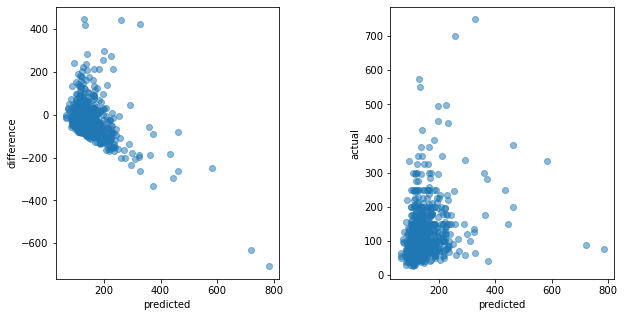

In [57]:
rf_model = models(RandomForestRegressor(n_estimators=500,
                                criterion='poisson'))

In [58]:
coefs_df = pd.DataFrame()

coefs_df['Most_influencing_features'] = X_train.columns
coefs_df['coefficient'] = rf_model.feature_importances_
coefs_df['absolute_coefficient'] = np.abs(rf_model.feature_importances_)

coefs_df.sort_values('absolute_coefficient', ascending=False).head(10)

,Most_influencing_features,coefficient,absolute_coefficient
5,number_of_bookings,0.263525,0.263525
2,number_of_reviews,0.231325,0.231325
1,n_amenities,0.173320,0.173320
0,avg_reviews,0.126179,0.126179
19,room_type_Private room,0.042750,0.042750
10,cancellation_policy_moderate,0.031008,0.031008
6,cancellation_policy_flexible,0.024482,0.024482
3,neighbourhood_Ballard,0.017779,0.017779
7,neighbourhood_Queen Anne,0.017728,0.017728
25,neighbourhood_Portage Bay,0.017023,0.017023


### Third Model: Gradient Boosting Regressor

The r^2 error is -0.0066
The Root Mean Square Error (RMSE) is 79.8778


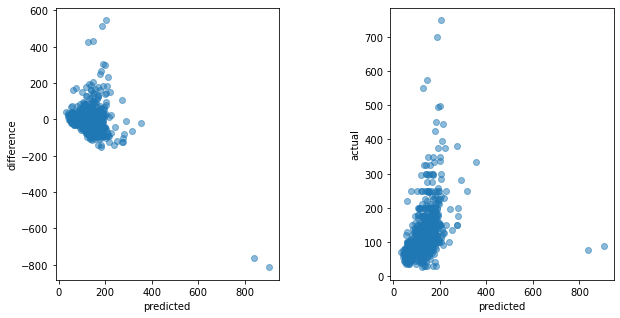

In [59]:
gbr_model = models(GradientBoostingRegressor())

In [60]:
coefs_df = pd.DataFrame()

coefs_df['Most_influencing_features'] = X_train.columns
coefs_df['coefficient'] = gbr_model.feature_importances_
coefs_df['absolute_coefficient'] = np.abs(gbr_model.feature_importances_)

coefs_df.sort_values('absolute_coefficient', ascending=False).head(10)

,Most_influencing_features,coefficient,absolute_coefficient
19,room_type_Private room,0.333546,0.333546
5,number_of_bookings,0.180255,0.180255
1,n_amenities,0.110019,0.110019
2,number_of_reviews,0.088742,0.088742
0,avg_reviews,0.086093,0.086093
10,cancellation_policy_moderate,0.056522,0.056522
6,cancellation_policy_flexible,0.048446,0.048446
25,neighbourhood_Portage Bay,0.034339,0.034339
7,neighbourhood_Queen Anne,0.023549,0.023549
13,neighbourhood_Fremont,0.010207,0.010207


### Fourth Model: ANN

Epoch 1/200
53/53 [==============================] - 1s 3ms/step - loss: 24639.6074 - rmse: 156.9701 - val_loss: 21613.1348 - val_rmse: 147.0141
Epoch 2/200
53/53 [==============================] - 0s 2ms/step - loss: 23417.9336 - rmse: 153.0292 - val_loss: 18708.4844 - val_rmse: 136.7790
Epoch 3/200
53/53 [==============================] - 0s 2ms/step - loss: 17426.0078 - rmse: 132.0076 - val_loss: 9436.3555 - val_rmse: 97.1409
Epoch 4/200
53/53 [==============================] - 0s 2ms/step - loss: 10935.3926 - rmse: 104.5724 - val_loss: 6895.1016 - val_rmse: 83.0368
Epoch 5/200
53/53 [==============================] - 0s 2ms/step - loss: 9830.7520 - rmse: 99.1501 - val_loss: 6352.2344 - val_rmse: 79.7009
Epoch 6/200
53/53 [==============================] - 0s 2ms/step - loss: 9396.4580 - rmse: 96.9353 - val_loss: 5971.6826 - val_rmse: 77.2767
Epoch 7/200
53/53 [==============================] - 0s 2ms/step - loss: 8827.3223 - rmse: 93.9538 - val_loss: 5546.3228 - val_rmse: 74.4736
E

Epoch 59/200
53/53 [==============================] - 0s 2ms/step - loss: 6810.4883 - rmse: 82.5257 - val_loss: 4672.8271 - val_rmse: 68.3581
Epoch 60/200
53/53 [==============================] - 0s 1ms/step - loss: 6979.0415 - rmse: 83.5407 - val_loss: 4702.0981 - val_rmse: 68.5718
Epoch 61/200
53/53 [==============================] - 0s 1ms/step - loss: 7130.1006 - rmse: 84.4399 - val_loss: 4678.4736 - val_rmse: 68.3994
Epoch 62/200
53/53 [==============================] - 0s 2ms/step - loss: 7010.8628 - rmse: 83.7309 - val_loss: 4680.9258 - val_rmse: 68.4173
Epoch 63/200
53/53 [==============================] - 0s 2ms/step - loss: 6968.2310 - rmse: 83.4759 - val_loss: 4681.1904 - val_rmse: 68.4192
Epoch 64/200
53/53 [==============================] - 0s 2ms/step - loss: 6929.2695 - rmse: 83.2422 - val_loss: 4664.8354 - val_rmse: 68.2996
Epoch 65/200
53/53 [==============================] - 0s 2ms/step - loss: 6909.0322 - rmse: 83.1206 - val_loss: 4681.1704 - val_rmse: 68.4191
Epoch 

<Figure size 720x576 with 0 Axes>

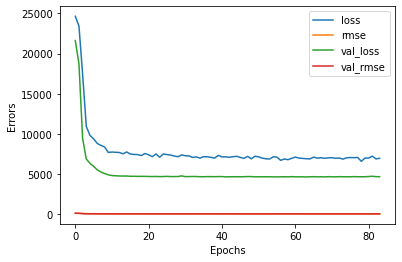

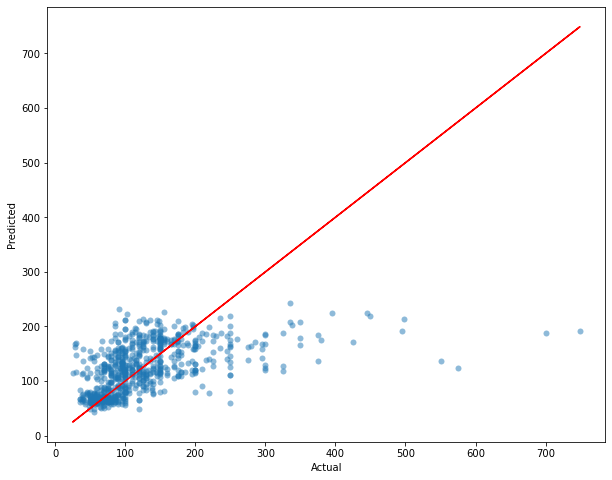

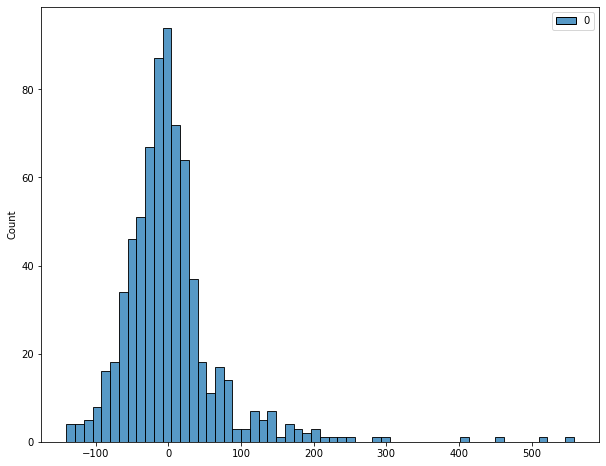

In [61]:
ann_models(X_train, X_test, hidden=3, neurons=20, learning_rate=3e-3, dropout=0.15)

### Step 7

This fourth model is, so far, the best prediction.
The price per night prediction using the ANN give good results, considering the RMSE of about 69.